In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import itertools
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
# parameters
settings = ['LAN', 'WAN']
parties = [0,1]
protocols = ['fss', 'scs', 'poly']

all_params = itertools.product(settings, parties, protocols)

data_filenames=['p0_lan.out', 'p0_wan.out', 'p1_lan.out', 'p1_wan.out']
raw_data = {}
pir_type = ""
N, n, local_time, mpc_time, total_time = 0, 0, 0., 0., 0.
for i_setting, setting in enumerate(settings):
    for p in parties:
        with open(data_filenames[p*len(settings) + i_setting]) as f:
            for line in f.read().splitlines():
                fields = line.split()
                if fields[0] == "PIR":
                    pir_type = fields[-1]
                    if pir_type == 'fss_cprg': pir_type = 'fss' 
                    raw_data[(setting, p, pir_type)] = []
                if fields[0] == "num_elements_server:":
                    N = fields[-1]
                if fields[0] == "num_elements_client:":
                    n = fields[-1]
                if fields[0] == "local_time:":
                    local_time = fields[-2]
                if fields[0] == "mpc_time:":
                    mpc_time = fields[-2]
                if fields[0] == "total_time:":
                    total_time = fields[-2]
                    raw_data[(setting, p, pir_type)] += \
                        [[N, n, local_time, mpc_time, total_time]]

data = {param : np.array(raw_data[param], dtype=np.float64) for param in raw_data.keys()}

# data always is (n, N)
# TODO: this should really be generated from the asymptotic parts
f_default = lambda data,a,b,c,d: a * data[:,0] * data[:,1] + \
            b * data[:,0] + c * data[:,1] + d
f_local = [
    { # server
        'fss': f_default,
        'fss_cprg': f_default,
        'scs': f_default,
        'poly': lambda data,a,b,c,d: 
            a * np.log2(data[:,1]) * data[:,1] + \
            b * np.log2(data[:,1]) + c * data[:,1] + d
    }, 
    { # client
        'fss': f_default,
        'fss_cprg': f_default,
        'scs': f_default,
        'poly': f_default
    },
]
f_mpc = { # same for both parties
    'fss': lambda data,a,b,c,d,e,f: (a*data[:,1] + \
        b*data[:,1]*np.log2(data[:,1]) + c *np.log2(data[:,1]) + d) * \
        (e*data[:,0] + f),
    'scs': lambda data,a,b,c: [a*n + b*n*np.log2(n) + \
        c #c*n*(np.log2(n)**2) + d
            for n in [data[:,0] + data[:,1]]][0], # wow, this is hacky
    'poly': f_default
}
f_mpc['fss_cprg'] = f_mpc['fss']

coeffs_local = {
    params : curve_fit(f_local[params[1]][params[2]], data[params][:,:2], data[params][:,2])[0]
    for params in data.keys()
}
coeffs_mpc = {
    params : curve_fit(f_mpc[params[2]], data[params][:,:2], data[params][:,3])[0]
    for params in data.keys()
}
coeffs_total = {
    params : curve_fit(f_mpc[params[2]], data[params][:,:2], data[params][:,4])[0]
    for params in data.keys()
}
#print("coeffs_local =", coeffs_local)
#print("coeffs_mpc =", coeffs_mpc)
#print("coeffs_total =", coeffs_total)

def model(phase, params):
    (setting, p, algo) = params
    if phase == 'local':
        return lambda data: f_local[p][algo](data, *(coeffs_local[params]))
    if phase == 'mpc':
        return lambda data: f_mpc[algo](data, *(coeffs_mpc[params]))
    if phase == 'local + mpc':
        return lambda data: model('local', params)(data) + model('mpc', params)(data)
    return None

/home/adria/.virtualenvs/metisml/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


========== ('LAN', 'Server') ==========


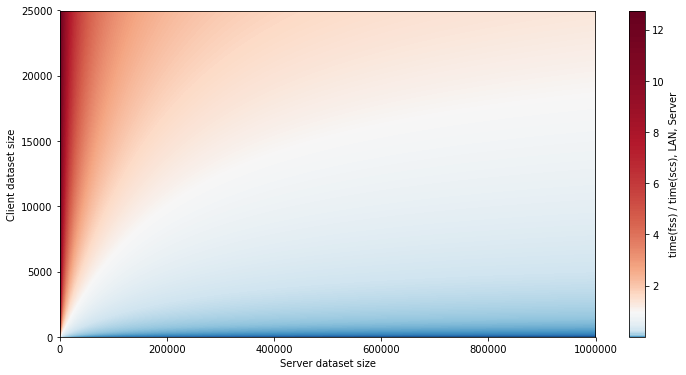

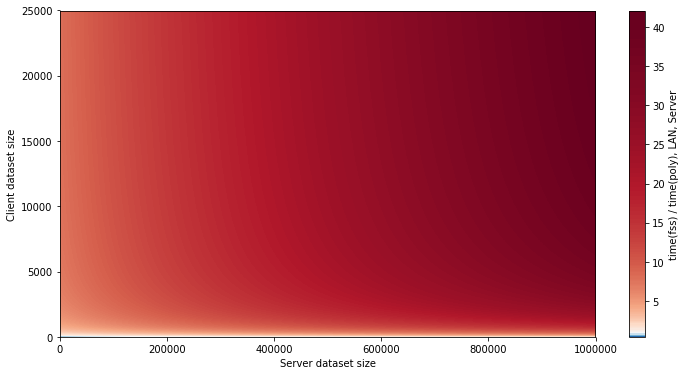

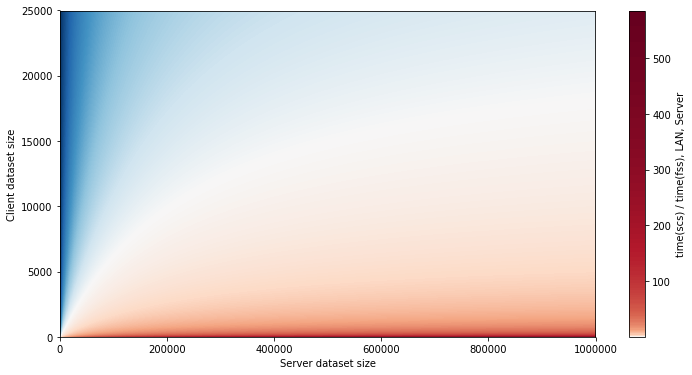

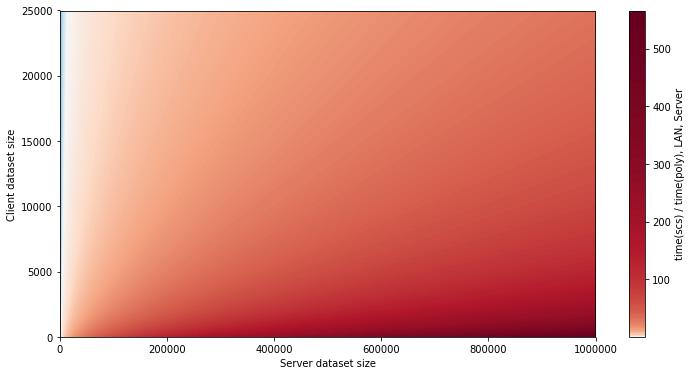

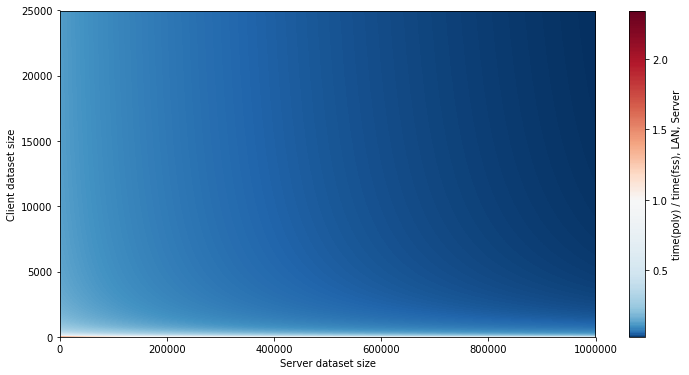

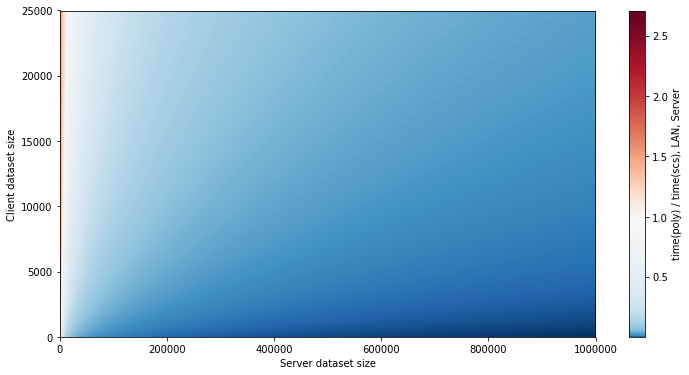

========== ('LAN', 'Client') ==========


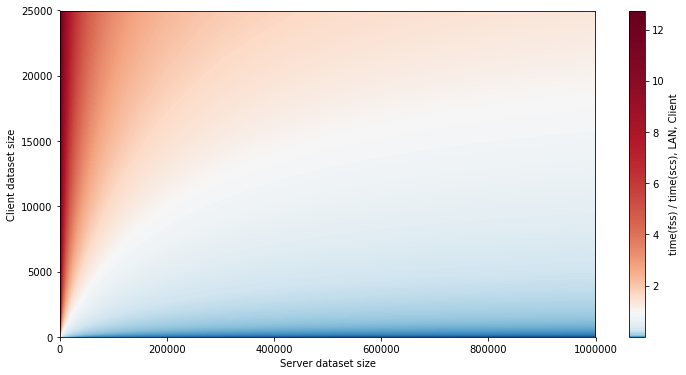

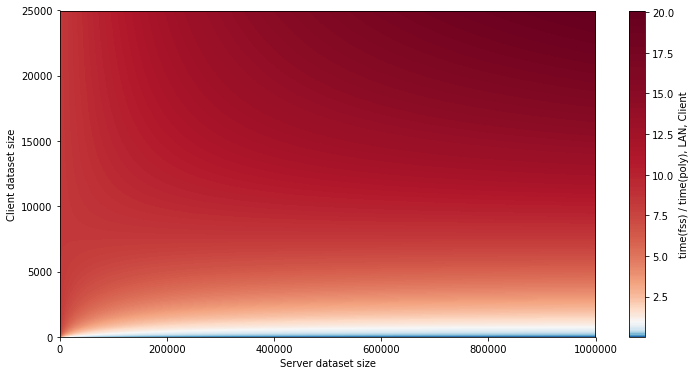

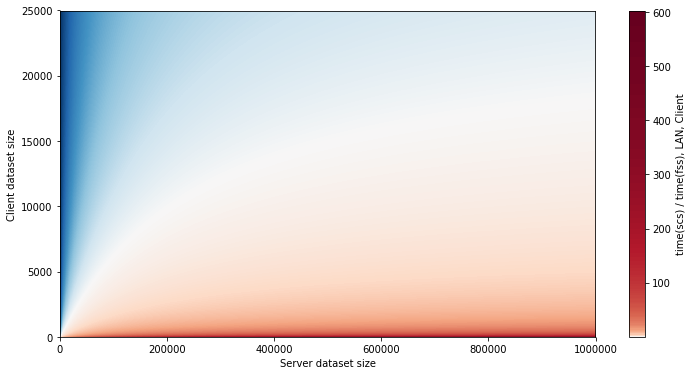

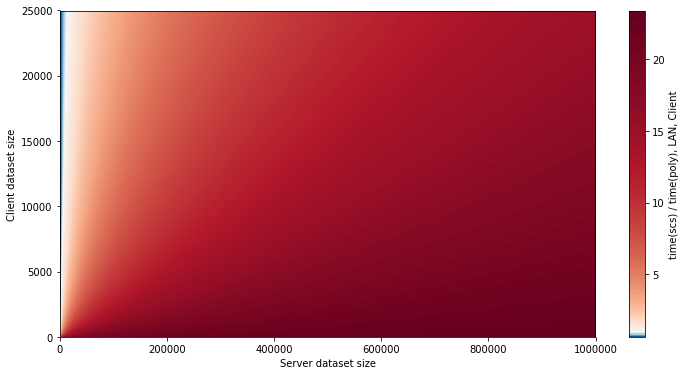

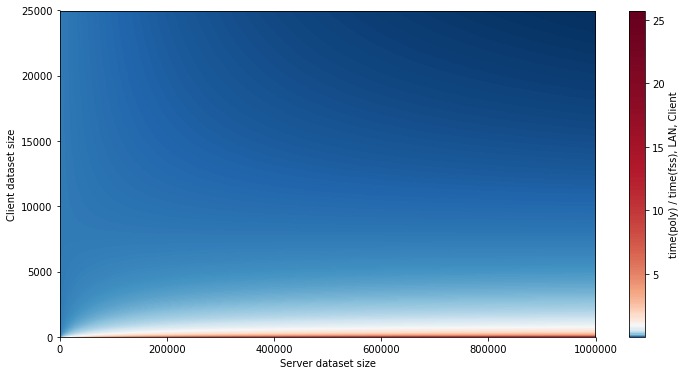

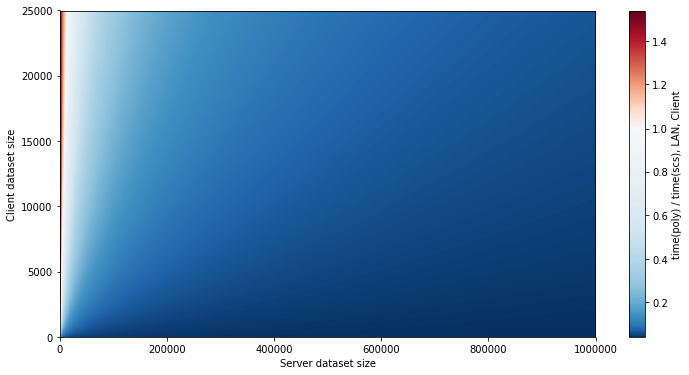

========== ('WAN', 'Server') ==========


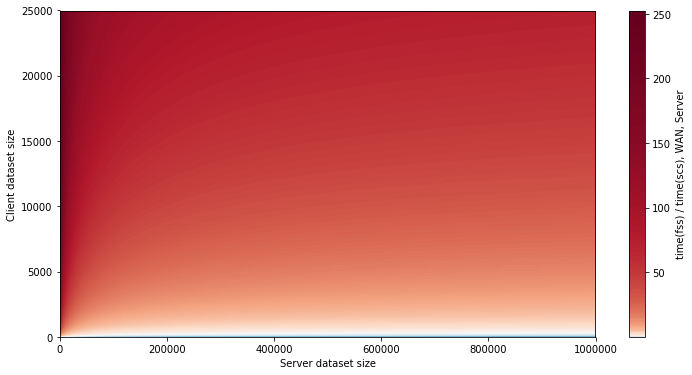

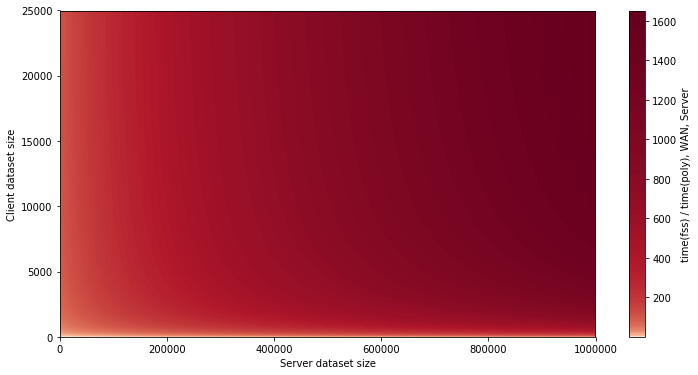

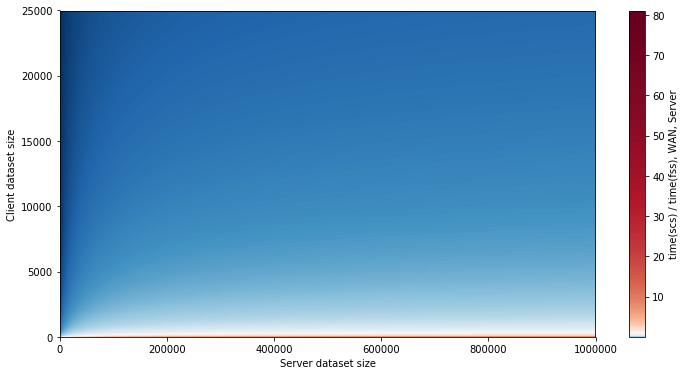

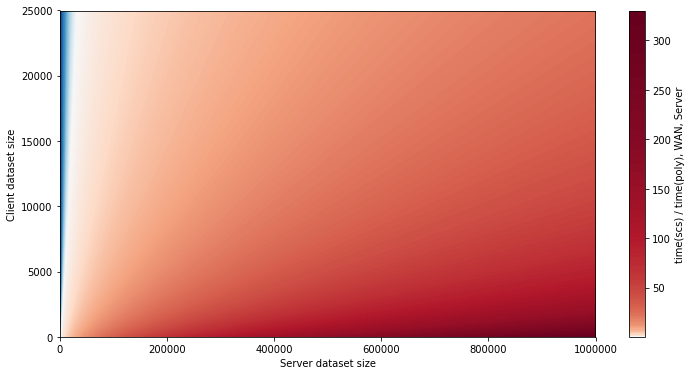

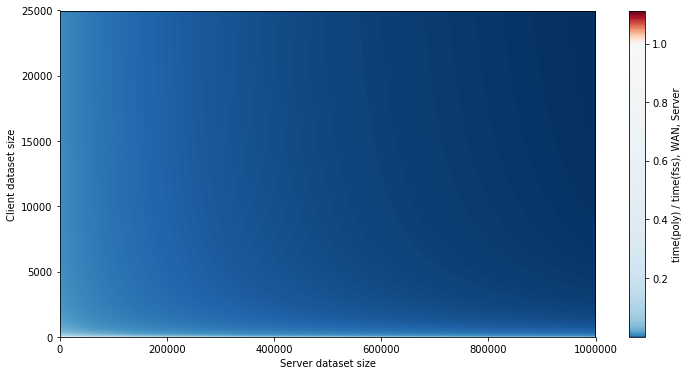

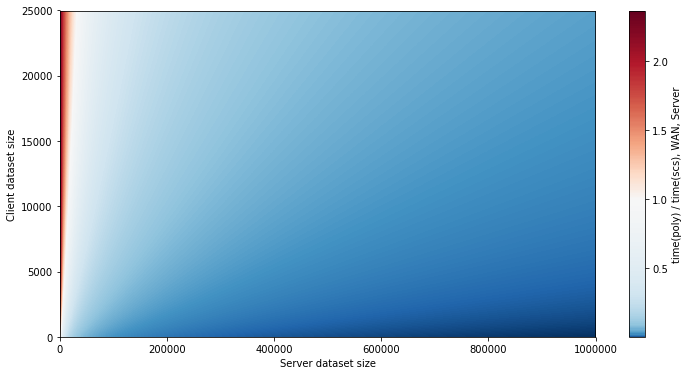

========== ('WAN', 'Client') ==========


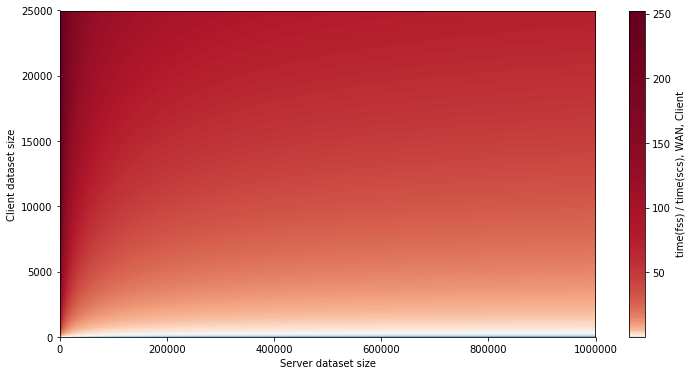

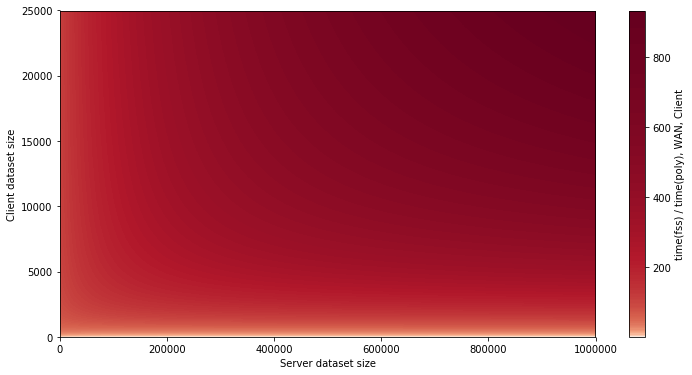

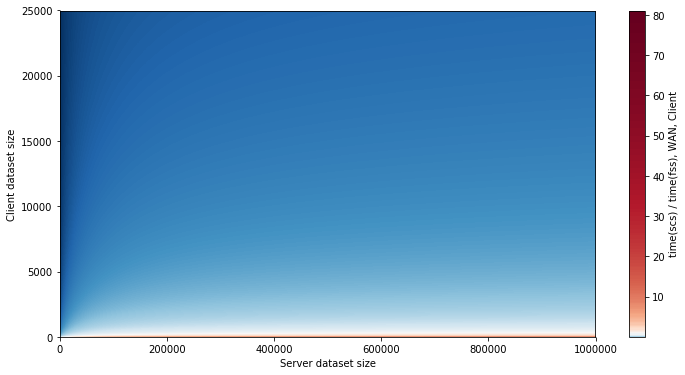

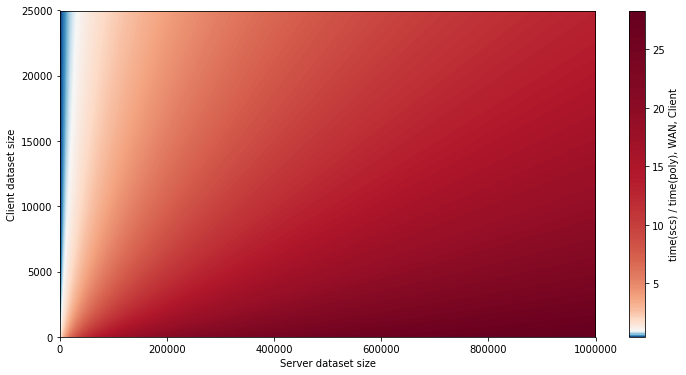

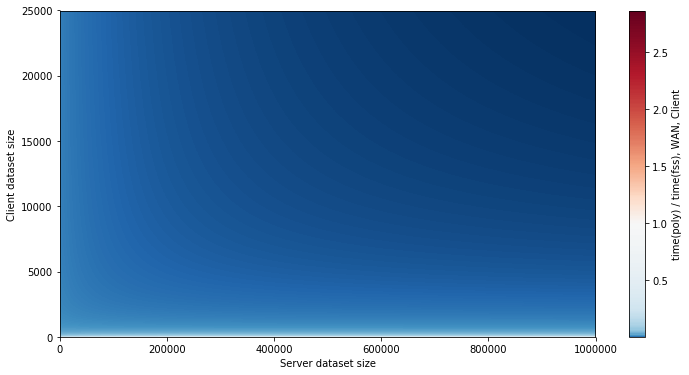

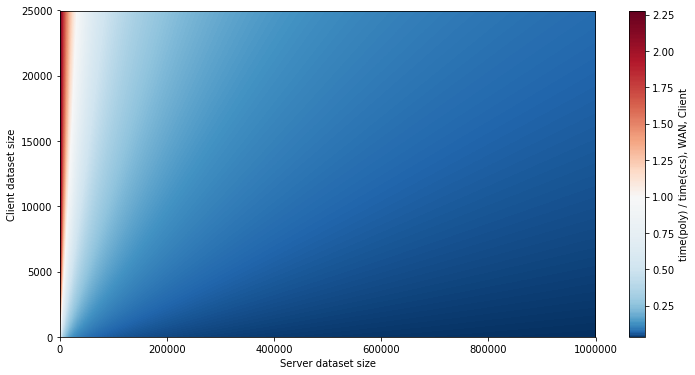

In [3]:
from scipy.interpolate import griddata
from matplotlib import colors
import itertools

client_min = 1
server_min = 1
client_max = 2.5e4
server_max = 1e6
server_sizes = np.arange(server_min, server_max+1, server_max/2000)
client_sizes = np.arange(client_min, client_max+1, client_max/2000)

def cartesian_product(x, y):
    # https://stackoverflow.com/q/11144513
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

# https://matplotlib.org/tutorials/colors/colormapnorms.html
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), np.log(x), y))
        #return np.ma.masked_array(np.interp(value, x, y))
        #return np.ma.masked_array(np.interp(
        #    np.power(np.array(value),0.5), np.power(np.array(x),0.5), y))

sizes = cartesian_product(server_sizes, client_sizes)
#settings = ['mpc', 'local'] # TODO: put this somewhere earlier
phases = ['local + mpc']
last = ("", "")
for setting, phase, p, algo1, algo2 in itertools.product(
    settings, phases, range(2), protocols, protocols
):
    p_name = "Server" if p == 0 else "Client"
    if (setting, p_name) != last:
        last = (setting, p_name)
        print('========== {} =========='.format(last))
    if algo1 == algo2: continue
    model1 = model(phase, (setting, p, algo1))
    model2 = model(phase, (setting, p, algo2))
    
    times_algo1 = np.maximum(0, model1(sizes))
    times_algo2 = np.maximum(0, model2(sizes))

    z = (times_algo1 / times_algo2).reshape((len(client_sizes), len(server_sizes))) # x-axis is inner dimension for imshow

    plt.imshow(z, origin='lower', aspect="auto", 
               norm=MidpointNormalize(midpoint=1.), cmap='RdBu_r',
               extent=(server_min, server_max, client_min, client_max))
    cb = plt.colorbar()
    cb.set_label('time({}) / time({}), {}, {}'.format(
        algo1, algo2, setting, p_name))
    plt.xlim((min(server_sizes), max(server_sizes)))
    plt.ylim((min(client_sizes), max(client_sizes)))

    plt.xlabel("Server dataset size")
    plt.ylabel("Client dataset size")
    #plt.savefig('benchmarks.pdf', bbox_inches='tight')
    plt.show()

========== Best algorithm ==========


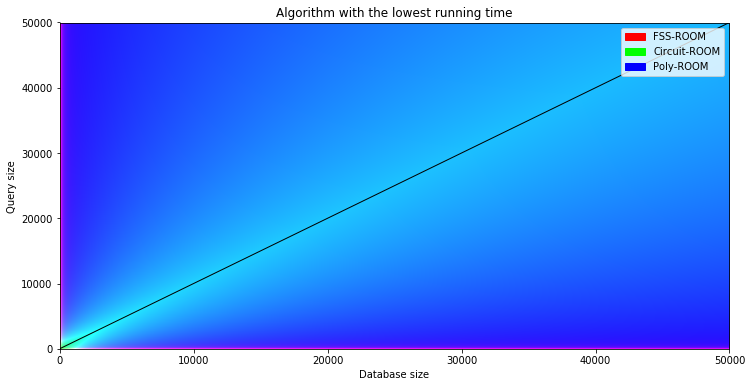

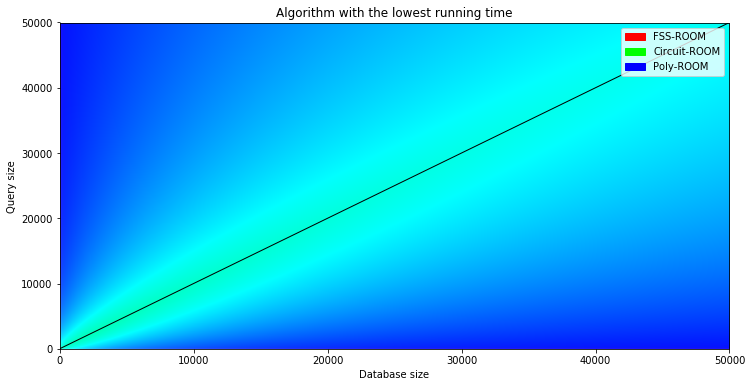

In [6]:
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib
import itertools

client_min = 1
server_min = 1
client_max = 50000
server_max = 50000
server_sizes = np.arange(server_min, server_max+1, server_max/2000)
client_sizes = np.arange(client_min, client_max+1, client_max/2000)

sizes = cartesian_product(server_sizes, client_sizes)
#settings = ['mpc', 'local'] # TODO: put this somewhere earlier

print('========== {} =========='.format("Best algorithm"))
algos = ['fss', 'scs', 'poly']
labels = ['FSS-ROOM', 'Circuit-ROOM', 'Poly-ROOM']
phases = ['local + mpc']
#z = np.max(z, axis=0, keepdims = True) - z

for (setting, phase) in itertools.product(settings, phases):
    times = np.array([model(phase, (setting, 0, algo))(sizes) for algo in algos])
    z = np.array([a.reshape((len(client_sizes), len(server_sizes))) for a in times])
    z = np.minimum(z, np.swapaxes(z, 1, 2))
    z = 1./z

    # compute rgb values; by mapping each protocol to one color and then computing the color of each pixel proportionally
    algo_colors = [[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]
    #algo_colors_inverse = [[0.,1.,1.],[1.,0.,1.],[1.,1.,0.]]
    # map times to colors
    z = np.tensordot(z, algo_colors, (0, 0))
    #z = np.tensordot(z, algo_colors_inverse, (0, 0))
    z /= np.max(z, axis=2, keepdims=True)

    im = plt.imshow(z, origin='lower', aspect="auto",
               extent=(server_min, server_max, client_min, client_max))
    plt.plot(server_sizes, server_sizes, 'black', linewidth=1, label='client = server')
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=algo_colors[i], label=labels[i] ) for i in range(3)]
    # put those patches as legend-handles into the legend
    plt.legend(handles=patches, loc=1)#, borderaxespad=0., bbox_to_anchor=(1.01, 1))

    plt.xlim((min(server_sizes), max(server_sizes)))
    plt.ylim((min(client_sizes), max(client_sizes)))

    plt.xlabel("Database size")
    plt.ylabel("Query size")
    plt.title("Algorithm with the lowest running time")

    plt.savefig('benchmarks_{}.pdf'.format(setting), bbox_inches='tight')
    plt.show()

#    def normalize_lightness(x):
#        hsv = colors.rgb_to_hsv(x)
#        hsv[:,:,1] = 0.66
#        hsv[:,:,2] = 1
#        return colors.hsv_to_rgb(hsv)
#
#    z = normalize_lightness(z)
#    algo_colors = normalize_lightness([algo_colors])[0]
#
#    im = plt.imshow(z, origin='lower', aspect="auto",
#               extent=(server_min, server_max, client_min, client_max))
#    plt.plot(server_sizes, server_sizes, 'black', linewidth=1, label='client = server')
#    # create a patch (proxy artist) for every color 
#    patches = [ mpatches.Patch(color=algo_colors[i], label=labels[i] ) for i in range(3)]
#    # put those patched as legend-handles into the legend
#    plt.legend(handles=patches, loc=1)#, borderaxespad=0., bbox_to_anchor=(1.01, 1))
#
#    plt.xlim((min(server_sizes), max(server_sizes)))
#    plt.ylim((min(client_sizes), max(client_sizes)))
#
#    plt.xlabel("Server dataset size")
#    plt.ylabel("Client dataset size")
#    plt.title("Algorithm with the lowest running time")
#
#    plt.show()

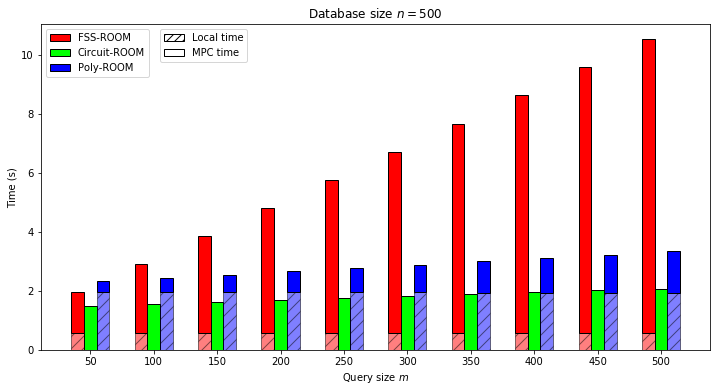

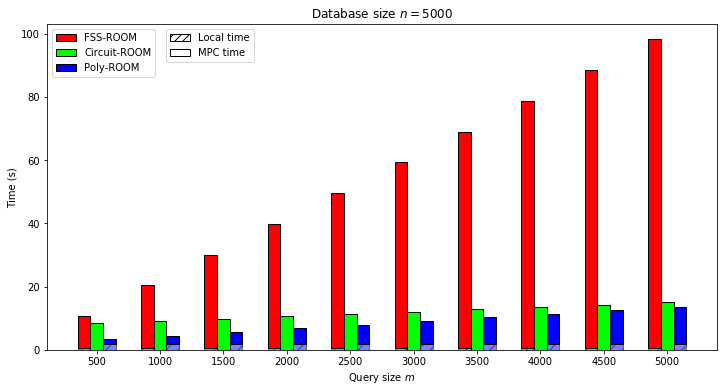

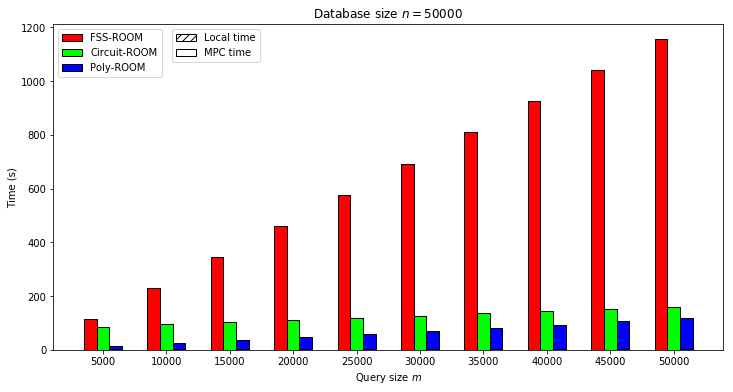

In [7]:
algos = ['fss', 'scs', 'poly']
#labels = ['FSS-ROOM', 'Circuit-ROOM', 'Poly-ROOM']
algo_colors = [[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]
phases = ['local', 'mpc']
phase_brightness = [0.8, 1]
phase_opacity = [0.5, 1]
setting = 'LAN'

num_bars = 10.
Ns = np.array([500, 5000, 50000])

for N in Ns:
    step = N / num_bars
    bar_width = step / 5.
    ns = np.arange(step, N + step, step)
    sizes = cartesian_product([N], ns)
    times = {}
    for (phase, algo) in itertools.product(phases, algos):
        times[phase, algo] =  model(phase, (setting, 0, algo))(sizes)
    rects = []
    for (i, algo) in enumerate(algos):
        bottom = np.array([0.] * len(ns))
        for (j, phase) in enumerate(phases):
            rect = plt.bar(ns + i * bar_width, times[phase, algo], bar_width,
                bottom = bottom,
                alpha = phase_opacity[j],
                color = np.array(algo_colors[i]),# * phase_brightness[j],
                edgecolor = 'black',
                hatch=("//" if phase == 'local' else None))
            bottom += times[phase, algo]
            if j == 1:
                rects += [rect]
    #plt.grid(which='major', axis='y', linestyle='--')
    first_legend = plt.legend(rects, labels)
    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor=[1., 1., 1.], hatch='///',label='Local time'),
                        mpatches.Patch(edgecolor='black', facecolor=[1., 1., 1.], label='MPC time')],
        loc='upper left', bbox_to_anchor=(.17, 1))
    plt.xticks(ns + bar_width, map(int, ns))
    plt.xlabel('Query size $m$')
    plt.ylabel('Time (s)')
    plt.title('Database size $n = {}$'.format(N))
    plt.savefig('comparison_{}_N{}.pdf'.format(setting, N), bbox_inches='tight')
    plt.show()


Naive Bayes (LAN)
Movies {'fss': 4.8481954542138519, 'scs': 201.11540451087265, 'poly': 2.5976424967048715}
Newsgroups {'fss': 3.9618431520495467, 'scs': 162.96612966249862, 'poly': 2.5273514412180913}
Languages, ngrams=1 {'fss': 1.5504402116658307, 'scs': 2.1371216709172307, 'poly': 2.2825629111678536}
Languages, ngrams=5 {'fss': 58.953099659180879, 'scs': 458.59452220017744, 'poly': 5.6460758355146679}


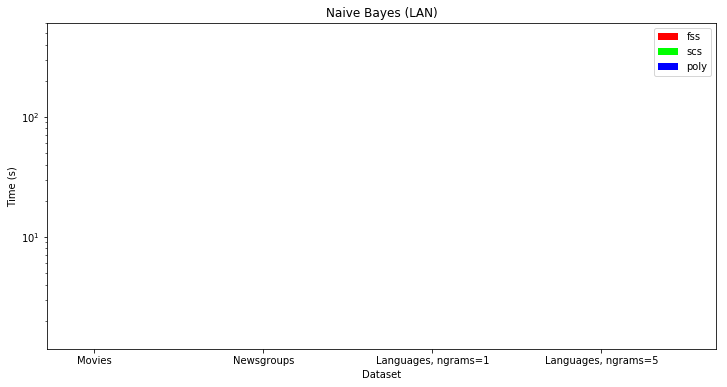


Naive Bayes (WAN)
Movies {'fss': 180.46220448649791, 'scs': 265.23784737804829, 'poly': 6.9635627270682896}
Newsgroups {'fss': 132.07909116235564, 'scs': 213.04520771403816, 'poly': 6.833746809408356}
Languages, ngrams=1 {'fss': 20.438534176160637, 'scs': 6.5446764983076351, 'poly': 6.3829042076355362}
Languages, ngrams=5 {'fss': 3466.3583560683151, 'scs': 627.88990173051673, 'poly': 12.687459940618744}


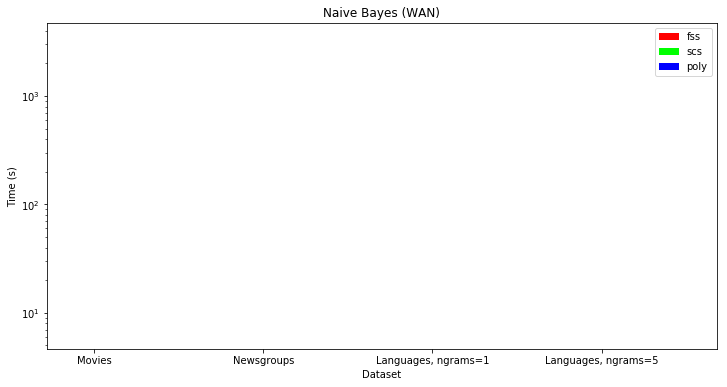

In [8]:
phase = 'local + mpc'
party = 0
algos = ['fss', 'scs', 'poly']
algo_colors = [[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]
bar_width = 0.2
#(d, sp_1)
datasets = {
    'Movies': (124247.,0.001),
    'Newsgroups': (101531.,0.001),
    'Languages, ngrams=1': (1017.,0.029),
    'Languages, ngrams=5': (272796.,0.0052),
}
for setting in ['LAN', 'WAN']:
    def bayes(d, sp_1):
        return {algo: model(phase, (setting, party, algo))(np.array([[d, sp_1 * d]]))[0] for algo in algos}
    print("Naive Bayes ({})".format(setting))
    timings = []
    for k in datasets.keys():
        timings += [bayes(*datasets[k])]
        print(k, timings[-1])
    rects = []
    for (i, algo) in enumerate(algos):
        rect = plt.bar(np.arange(len(datasets)) + i * bar_width, [t[algo] for t in timings], bar_width,
            color = np.array(algo_colors[i]))
        rects += [rect]
    plt.legend(rects, algos)
    plt.xticks(range(len(datasets)), datasets.keys())
    plt.xlabel('Dataset')
    plt.ylabel('Time (s)')
    plt.yscale('log')
    plt.title("Naive Bayes ({})".format(setting))
    plt.savefig('bayes_{}.pdf'.format(setting), bbox_inches='tight')
    plt.show()
    print()
    